# Introduction

## Technical details
To do this analysis, we need to overcome some technical aspects:
- Test a Bayesian model at the suburban level
- Model accessibility at the meshblock level
- Gather modeled meshblock accessibilities at the suburban level
- Compare suburban averages in Wellington


In [1]:
# Import some packages
import warnings
import pandas as pd
import osmnx as ox 
import networkx as nx
import pandana as pa

import geopandas 
import numpy as np
import seaborn as sns
import folium
import yaml
from importlib import reload
from shapely.geometry import Point, Polygon, LineString
from descartes import PolygonPatch
import matplotlib.pyplot as plt
import pystan

import utils.data_processing as dp
import utils.accessibility_analysis as aa
import utils.util as ut
import utils.stan_utils as su

# Some configs
warnings.filterwarnings('ignore')
ox.config(log_console=True, use_cache=True)
pd.set_option('display.max_columns', 200)
%matplotlib inline

In [2]:
# Define bounding box (W, S, E, N) for the area of Wellington we're interested in
# Copied from http://boundingbox.klokantech.com/

general_bbox = [174.57,-41.38,174.84,-41.1527] # original

# general_bbox = [174.613106,-41.36238,174.89541,-41.134213] # new: making sure I don't miss any Tawa areas

# Separate out the bounding box list into 4 vertices. 
south = general_bbox[1]
west = general_bbox[0]
north = general_bbox[3]
east = general_bbox[2]

# Set OSM bounding box
osm_bbox = [south, west, north, east]

# centroids of bounding box
mean_lat = np.mean([north, south])
mean_lon = np.mean([west, east])

# Datasets

| Dataset | Description | Format | Link |
| :-----: | :---------: | :----: | :--: |
| WCC playground locations | jsdh | .zip| |
| WCC suburb boundaries | ;lf | .gdb | |
| StatsNZ 2019 meshblock boundaries | ;lf | .gdb | |
| Wellington street network without elevation | ksfj| kjfd | lkd| 
| Wellington street network with elevation | ksfj| kjfd | lkd| 

## WCC Playgrounds

In [3]:
wcc_playgrounds = geopandas.read_file('zip://./data/WCC_Playgrounds.zip')
wcc_playgrounds['lon'] = wcc_playgrounds['geometry'].apply(lambda p: p.x)
wcc_playgrounds['lat'] = wcc_playgrounds['geometry'].apply(lambda p: p.y)
wcc_playgrounds = wcc_playgrounds.to_crs(epsg=4167)

In [4]:
map_playground = folium.Map(location=[mean_lat, mean_lon], zoom_start = 11)

for each in wcc_playgrounds.iterrows():
    folium.Marker(location = [each[1]['lat'],each[1]['lon']]).add_to(map_playground)

map_playground

## Boundary files: Suburbs and meshblocks

In [5]:
wcc_suburbs = geopandas.read_file('zip://./data/WCC_Suburbs_Boundaries.zip')
meshblock= geopandas.read_file('./data/meshblock-higher-geographies-2019-generalised-4326.gdb')
wlg_meshblock = meshblock.query('REGC2019_V1_00_NAME == "Wellington Region"')

# Two different types of joining operations
wlg_meshblock_suburbs = geopandas.sjoin(wcc_suburbs, wlg_meshblock, op='contains', how='right')
wlg_meshblock_suburbs_ov = geopandas.overlay(wcc_suburbs, wlg_meshblock, how='identity')

In [6]:
wlg_meshblock_suburbs.crs

{'init': 'epsg:4326'}

In [7]:
# Statistical Area Unit 2
sa2 = geopandas.read_file('./data/area-unit-2013.gdb')
sa2_proj = sa2.to_crs(wlg_meshblock_suburbs.crs)

In [8]:
sa2.head()

,AU2013_V1_00,AU2013_V1_00_NAME,AREA_SQ_KM,LAND_AREA_SQ_KM,Shape_Length,geometry
0,500202,Karikari Peninsula-Maungataniwha,791.188485,784.395200,285586.495714,(POLYGON ((1636527.006899834 6150940.062399864...
1,500203,Taipa Bay-Mangonui,5.545054,5.545054,25711.852169,(POLYGON ((1648130.469600201 6128680.422100067...
2,500204,Herekino,396.511344,391.067273,172051.055675,(POLYGON ((1622142.151400089 6120287.439599991...
3,500205,Ahipara,8.000104,8.000104,20638.880336,(POLYGON ((1615173.015799999 6110225.846300125...
4,500206,North Cape,690.237222,626.035844,177953.473387,(POLYGON ((1601317.232200146 6194284.575900078...


In [9]:
# Residential polygons
res = geopandas.read_file('./data/nz-residential-area-polygons-topo-150k.gdb')
wlg_res = res.query('name == "Wellington"')
wlg_res_poly_suburbs_ov = geopandas.overlay(wcc_suburbs, wlg_res, how='identity')

In [10]:
wlg_sa2_suburbs_ov = geopandas.overlay(wcc_suburbs, sa2_proj, how='identity')

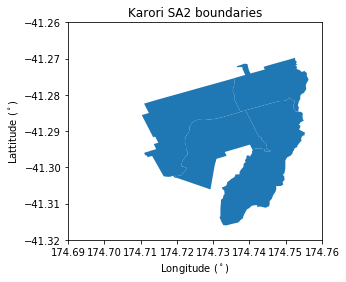

In [11]:
sa2_proj[sa2_proj['AU2013_V1_00_NAME'].str.contains('Karori')].plot()
plt.ylim(-41.320, -41.260)
plt.xlim(174.69, 174.76)
plt.title('Karori SA2 boundaries');
plt.ylabel('Lattitude ($^\circ$)');
plt.xlabel('Longitude ($^\circ$)');

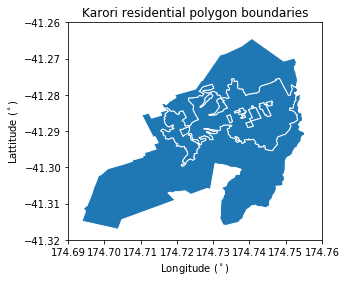

In [12]:
wlg_res_poly_suburbs_ov.query('suburb == "Karori"').plot(edgecolor='white')
plt.ylim(-41.320, -41.260)
plt.xlim(174.69, 174.76)
plt.title('Karori residential polygon boundaries');
plt.ylabel('Lattitude ($^\circ$)');
plt.xlabel('Longitude ($^\circ$)');

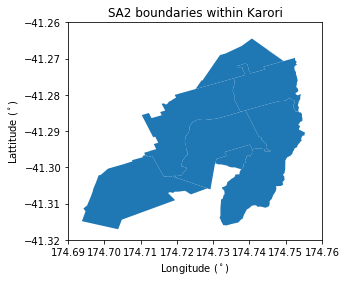

In [13]:
wlg_sa2_suburbs_ov.query('suburb == "Karori"').plot()
plt.ylim(-41.320, -41.260)
plt.xlim(174.69, 174.76)
plt.title('SA2 boundaries within Karori');
plt.ylabel('Lattitude ($^\circ$)');
plt.xlabel('Longitude ($^\circ$)');

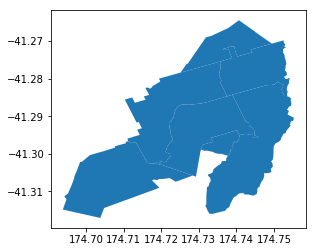

In [14]:
wlg_sa2_suburbs_ov[wlg_sa2_suburbs_ov['suburb'] == 'Karori']['geometry'].plot()   


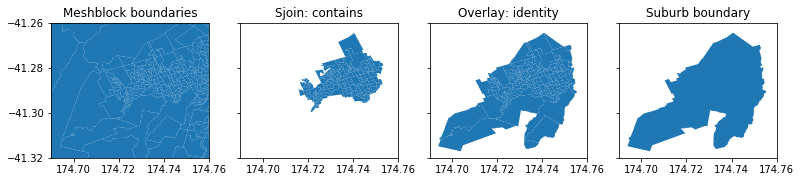

In [15]:
# Set up figure
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(13,10))

# Plot meshblocks contained within suburb boundary
wlg_meshblock.plot(ax=ax1)
plt.ylim(-41.320, -41.260)
plt.xlim(174.69, 174.76)
ax1.set_title('Meshblock boundaries');

# Plot meshblocks contained within suburb boundary
wlg_meshblock_suburbs.query('suburb == "Karori"').plot(ax=ax2)
plt.ylim(-41.320, -41.260)
plt.xlim(174.69, 174.76)
ax2.set_title('Sjoin: contains');

# Plot meshblocks intersecting with suburb boundary
wlg_meshblock_suburbs_ov.query('suburb == "Karori"').plot(ax=ax3)
plt.ylim(-41.320, -41.260)
plt.xlim(174.69, 174.76)
ax3.set_title('Overlay: identity');

# Suburb boundary within meshblock limits
wcc_suburbs.query('suburb == "Karori"').plot(ax=ax4)
plt.ylim(-41.320, -41.260)
plt.xlim(174.69, 174.76)
ax4.set_title('Suburb boundary');

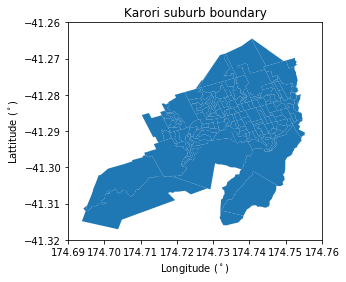

In [16]:
# Plot meshblocks intersecting with suburb boundary
wlg_meshblock_suburbs_ov.query('suburb == "Karori"').plot()
plt.ylim(-41.320, -41.260);
plt.xlim(174.69, 174.76);
plt.title('Karori suburb boundary');
plt.ylabel('Lattitude ($^\circ$)');
plt.xlabel('Longitude ($^\circ$)');

In [17]:
wlg_meshblock_suburbs_ov.query('suburb == "Karori"')[['suburb', 'postcode', 'MB2019_V1_00', 'geometry']].head()

,suburb,postcode,MB2019_V1_00,geometry
917,Karori,6012.0,2104100,POLYGON ((174.7527410567269 -41.27200381936174...
934,Karori,6012.0,2106100,POLYGON ((174.7533828776446 -41.28300381209932...
942,Karori,6012.0,2105503,(POLYGON ((174.7530386517898 -41.2800340600980...
944,Karori,6012.0,2149500,POLYGON ((174.7535317353109 -41.28234654562732...
947,Karori,6012.0,2149400,(POLYGON ((174.754264330901 -41.27988740170357...


## Wellington street network: without elevation
Getting the Wellington street network in a form suitable for accessibility analysis is trivial. The previous posts [on fuel station](https://shriv.github.io/Fuel-Stations-Analysis-Part-3/) and [playground](https://shriv.github.io/Playgrounds-vs-pubs/) acessibility cover the process in detail. Without delving into the specifics, the process basically involves calling _pandana's_ OpenStreetMap loader. And voila, we have a street network that can be consumed by _pandana_ for the accessibility analysis. 

The _pandana_ network above has edge weights in the default units of metres, which means that the accessibility analyses will also be in metres. We can post-hoc convert the distance units to travel time with an average walking speed of 5 km/h or, 83 m/minute if we want travel time in minutes. 

## Wellington street network: with elevation

In [18]:
# Open the API keys stored in a YAML file
with open("utils/api_keys.yaml", 'r') as stream:
    data_loaded = yaml.load(stream)

# Get Google Elevation API key
google_elevation_api_key = data_loaded['google_elevation_api_key'][0]

# Create an OSMNX walking street netwoek for the Wellington bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type='walk')

# Add elevation values for the nodes in the OSMNX graph
G = ox.add_node_elevations(G, api_key=google_elevation_api_key)

# Generate an edge grade (inclination) with the elevations at the nodes
G = ox.add_edge_grades(G)

# Accessibility analysis using network with street gradients

## Reproducing existing accessibility analysis

In [19]:
# Get nodes and edges as geodataframes (gdfs) from OSMNX network
graph_df = ox.graph_to_gdfs(G)
nodes_gdfs = graph_df[0]
edges_gdfs = graph_df[1]

In [20]:
# Setting indices of Edges gdfs to match expected dataframe for Pandana
edges_gdfs['from_idx'] = edges_gdfs['u']
edges_gdfs['to_idx'] = edges_gdfs['v']
edges_gdfs= edges_gdfs.set_index(['from_idx', 'to_idx'])
edges_gdfs.index.names= ['','']

# Setting indices of Nodes gdfs to match expected dataframe for Pandana
nodes_gdfs.index.name = 'id'

## Pandana network with travel times

In [21]:
# Break up network
edges_gdfs_undir_inv, edges_gdfs_undir, nodes_gdfs = dp.separate_elevation_graph_by_direction(G)

# Create pandana network objects for flat and hilly terrain travel times
network = pa.Network(nodes_gdfs['x'], nodes_gdfs['y'],
                     edges_gdfs_undir['u'], edges_gdfs_undir['v'], 
                     edges_gdfs_undir[['time_5khr']])

network_hills = pa.Network(nodes_gdfs['x'], nodes_gdfs['y'],
                           edges_gdfs_undir['u'], edges_gdfs_undir['v'], 
                           edges_gdfs_undir[['time_tobler']])

network_hills_inv = pa.Network(nodes_gdfs['x'], nodes_gdfs['y'],
                               edges_gdfs_undir_inv['u'], edges_gdfs_undir_inv['v'], 
                               edges_gdfs_undir_inv[['time_tobler']])

In [22]:
edges_gdfs_undir[['name', 'grade', 'length', 'osmid', 'maxspeed']].head()

name   grade   length      osmid maxspeed
                                                                           
1259077823 1259072929  Truscott Avenue  0.1319   66.800  110175609       50
           1259072943  Truscott Avenue -0.0475   65.443  110175609       50
           6083853567  John Sims Drive -0.1116  177.292  110176112       50
1259077824 6083853567  John Sims Drive  0.1650   13.022  110176112       50
1259077827 465611807   Cambrian Street  0.0396   71.272  107284021       50

## Pandana accessibility with hill-accounted travel times

In [23]:
# Calculate accessibility
playground_accessibility = aa.get_accessibility(network, wcc_playgrounds, distance=60, num_pois=10)
playground_hills_accessibility = aa.get_accessibility(network_hills, wcc_playgrounds, distance=60, num_pois=10)
playground_hills_inv_accessibility = aa.get_accessibility(network_hills_inv, wcc_playgrounds, distance=60, num_pois=10)

In [24]:
total_flat = (playground_accessibility[1] + playground_accessibility[1])
total_hills_1 = (playground_hills_inv_accessibility[1] + playground_hills_accessibility[1])
total_hills_2 = (playground_hills_inv_accessibility[2] + playground_hills_accessibility[2])

# Accessibility by Wellington suburb

## Distributions within suburbs

In [1]:
#analysis = 'residential polygons'
analysis = 'suburb boundaries'

In [3]:

# Get lat and lon coordinates for accessibility values
orig_nodes = network_hills.nodes_df 
df_joined = pd.merge(orig_nodes.reset_index(), total_hills_1.reset_index(), how='inner')
df_joined.columns = ['node_id', 'lon', 'lat', 'accessibility']
# Convert lat and lon to geoseries
df_joined_coords = dp.coords_df_to_geopandas_points(df_joined, crs={'init': 'epsg:4167'})

# Extract only the residential polygons
res_polys_only = wlg_res_poly_suburbs_ov[(~wlg_res_poly_suburbs_ov['t50_fid'].isnull())]

if analysis == 'residential polygons':
    # Get accessibility within residential polygons
    playground_df = geopandas.sjoin(res_polys_only, df_joined_coords, op='contains').drop('index_right', axis=1)
else:
    # Join to suburb boundaries
    playground_df = geopandas.sjoin(wcc_suburbs, df_joined_coords, op='contains').drop('index_right', axis=1)


#df_sel = playground_df[playground_df['AU2013_V1_00_NAME'].isin(['Karori Park', 'Te Kainga',
#                                          'Karori South', 'Karori East',
#                                         'Newlands South', 'Hataitai North', 
#                                          'Strathmore Park', 'Raroa',
#                                         'Ngaio South', 'Brooklyn'])]

df_sel = playground_df[playground_df['suburb'].isin(['Karori'])]

g = sns.FacetGrid(col='suburb', data=df_sel, size=4, col_wrap=5)
g.map(plt.hist, 'accessibility', normed=True, bins=50)
g.map(ut.vertical_average_lines, 'accessibility')
plt.xlim(0,60);
#plt.ylim(0, 0.0035);

NameError: name 'network_hills' is not defined

## Visualising accessibility within suburb boundaries

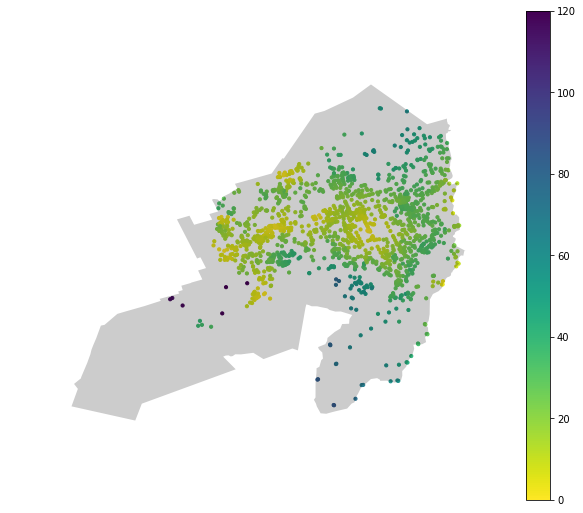

In [27]:
karori = playground_df[playground_df['suburb'] == 'Karori']
karori_mesh = wlg_meshblock_suburbs[wlg_meshblock_suburbs['suburb'] == "Karori"]

fig = plt.figure(figsize=(10,9))
#f, ax = plt.subplots()
ax = fig.add_subplot(1,1,1)
a0 = ax.scatter(karori['lon'], 
                karori['lat'], 
                s=10,
                c=karori['accessibility'],
                cmap='viridis_r')

#wlg_meshblock_suburbs[wlg_meshblock_suburbs['suburb'] == 'Karori'].plot(ax=ax, alpha=0.9)    
wcc_suburbs[wcc_suburbs['suburb'] == 'Karori']['geometry'].plot(ax=ax, color='black', alpha=0.2)   

cbar1 = fig.colorbar(a0, ax=ax)
ax.axis('off')
cbar1.set_clim(0, 120)
plt.show()

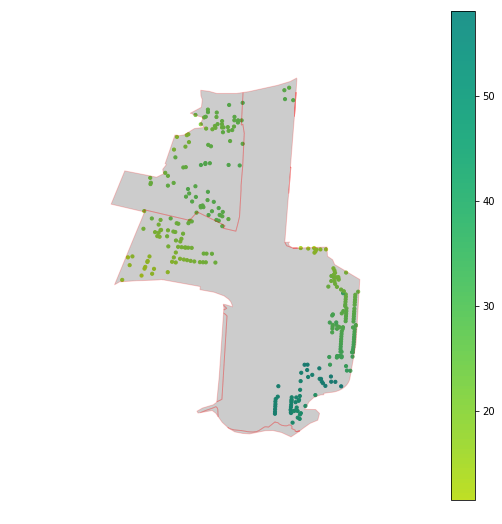

In [28]:
karori = playground_df[playground_df['suburb'] == 'Rongotai']
karori_mesh = wlg_sa2_suburbs_ov[wlg_sa2_suburbs_ov['suburb'] == "Karori"]

fig = plt.figure(figsize=(10,9))
#f, ax = plt.subplots()
ax = fig.add_subplot(1,1,1)

#wlg_meshblock_suburbs[wlg_meshblock_suburbs['suburb'] == 'Karori'].plot(ax=ax, alpha=0.9)    
a0 = ax.scatter(karori['lon'], 
                karori['lat'], 
                s=10,
                c=karori['accessibility'],
                cmap='viridis_r')
wlg_sa2_suburbs_ov[wlg_sa2_suburbs_ov['suburb'] == 'Rongotai']['geometry'].plot(ax=ax, color='black', edgecolor='red', alpha=0.2)   

cbar1 = fig.colorbar(a0, ax=ax)
ax.axis('off')
cbar1.set_clim(0, 120)
plt.show()

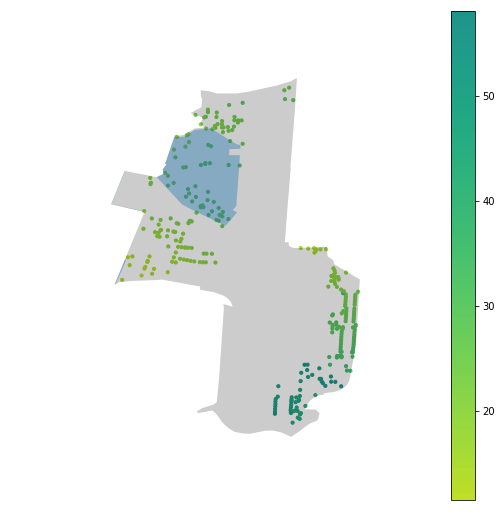

In [29]:
karori = playground_df[playground_df['suburb'] == 'Rongotai']
karori_mesh = wlg_res_poly_suburbs_ov[wlg_res_poly_suburbs_ov['suburb'] == "Rongotai"]

fig = plt.figure(figsize=(10,9))
#f, ax = plt.subplots()
ax = fig.add_subplot(1,1,1)

#wlg_meshblock_suburbs[wlg_meshblock_suburbs['suburb'] == 'Karori'].plot(ax=ax, alpha=0.9)    
a0 = ax.scatter(karori['lon'], 
                karori['lat'], 
                s=10,
                c=karori['accessibility'],
                cmap='viridis_r')
wcc_suburbs[wcc_suburbs['suburb'] == 'Rongotai']['geometry'].plot(ax=ax, color='black', alpha=0.2)   

wlg_res_poly_suburbs_ov[(wlg_res_poly_suburbs_ov['suburb'] == 'Rongotai') & 
                        (~wlg_res_poly_suburbs_ov['t50_fid'].isnull())].plot(ax=ax, alpha=0.4)

cbar1 = fig.colorbar(a0, ax=ax)
ax.axis('off')
cbar1.set_clim(0, 120)
plt.show()

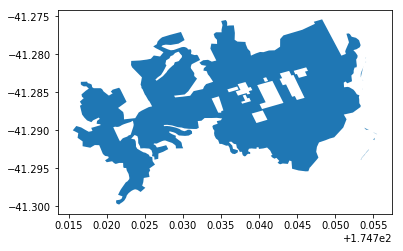

In [30]:
wlg_res_poly_suburbs_ov[(wlg_res_poly_suburbs_ov['suburb'] == 'Karori') & (~wlg_res_poly_suburbs_ov['t50_fid'].isnull())].plot()

In [31]:
unstacked_poly = wlg_res_poly_suburbs_ov.set_index(['t50_fid'])['geometry'].apply(pd.Series).stack().reset_index(name='geometry')
unstacked_poly.tail()

,t50_fid,level_1,geometry
613,NaN,9,POLYGON ((174.7353105300001 -41.28739130899993...
614,NaN,10,POLYGON ((174.7266746510001 -41.28304035599996...
615,NaN,11,POLYGON ((174.7208309800001 -41.28959583299996...
616,NaN,0,"POLYGON ((174.759869683805 -41.3237081287967, ..."
617,NaN,0,"POLYGON ((174.744012619715 -41.2297466358026, ..."


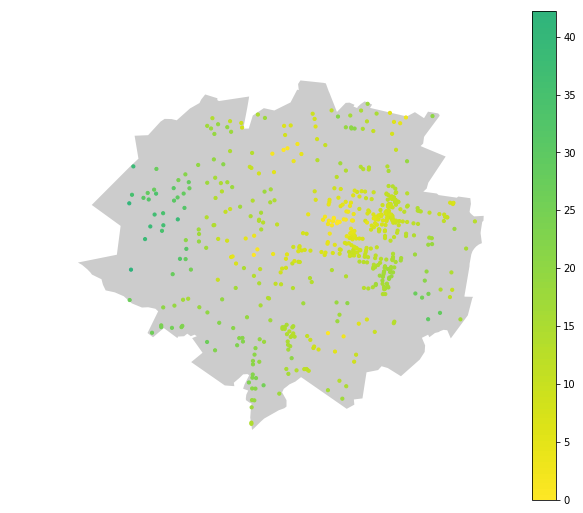

In [32]:
jville = playground_df[playground_df['suburb'] == 'Johnsonville']

fig = plt.figure(figsize=(10,9))
#f, ax = plt.subplots()
ax = fig.add_subplot(1,1,1)

wcc_suburbs[wcc_suburbs['suburb'] == 'Johnsonville']['geometry'].plot(ax=ax, color='black', alpha=0.2)    
#wlg_meshblock_suburbs[wlg_meshblock_suburbs['suburb'] == 'Johnsonville'].plot(ax=ax)    

a0 = ax.scatter(jville['lon'], 
                jville['lat'], 
                s=10,
                c=jville['accessibility'],
                cmap='viridis_r')

cbar1 = fig.colorbar(a0, ax=ax)
cbar1.set_clim(0, 120)
ax.axis('off')
plt.show()

# Stan experiments
This section is all about writing Bayesian models with Stan. 

In [33]:
uni_norm_model = su.load_or_generate_stan_model('stan', 'univariate_normal')
lower_trunc_norm_model = su.load_or_generate_stan_model('stan', 'lower_truncated_univariate_normal')
trunc_norm_model = su.load_or_generate_stan_model('stan', 'truncated_univariate_normal')


stan/univariate_normal.pkl
stan/lower_truncated_univariate_normal.pkl
stan/truncated_univariate_normal.pkl


In [34]:
# Run precompiled model
hataitai = playground_df[playground_df['suburb'] == 'Hataitai']
karori = playground_df[playground_df['suburb'] == 'Karori']
karori = karori[karori['accessibility'] > 0]

karori_dat = {'n': karori.shape[0],
              'y': karori['accessibility'].values,}
karori_fit = uni_norm_model.sampling(karori_dat, chains=4)
print(karori_fit)


Inference for Stan model: anon_model_cc3fc1beb21cbbe7b94ad66105c98210.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       23.0  6.3e-3   0.36  22.26  22.75   23.0  23.24   23.7   3320    1.0
sigma   14.28  4.4e-3   0.25   13.8  14.11  14.27  14.44  14.79   3246    1.0
y_pred  23.03    0.23  14.14  -4.63  13.13  23.35  32.72  50.02   3844    1.0
lp__    -5086    0.02   1.02  -5089  -5087  -5086  -5085  -5085   1690    1.0

Samples were drawn using NUTS at Sat May 11 23:03:17 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


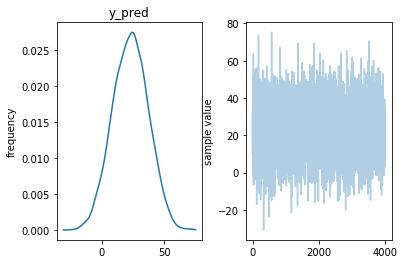

In [35]:
fig = karori_fit.plot(pars=['y_pred'])
fig.subplots_adjust(hspace=1.0, wspace=0.3)

(-30, 80)

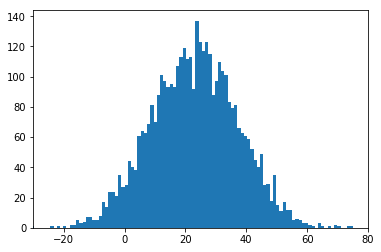

In [36]:
plt.hist(karori_fit['y_pred'], bins=100);
plt.xlim(-30, 80)

In [37]:
# Run precompiled model
hataitai = playground_df[playground_df['suburb'] == 'Hataitai']

hataitai_dat = {'n': hataitai.shape[0],
                'y': hataitai['accessibility'].values,}
hataitai_fit = uni_norm_model.sampling(hataitai_dat, chains=4)
print(hataitai_fit)


Inference for Stan model: anon_model_cc3fc1beb21cbbe7b94ad66105c98210.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      16.78  4.7e-3   0.29  16.23   16.6  16.79  16.97  17.34   3669    1.0
sigma    5.88  3.6e-3    0.2    5.5   5.74   5.88   6.02   6.28   3125    1.0
y_pred  16.68    0.09   5.92   5.23   12.6  16.65  20.67  28.48   4000    1.0
lp__   -963.4    0.02   0.98 -966.1 -963.8 -963.1 -962.7 -962.4   1580    1.0

Samples were drawn using NUTS at Sat May 11 23:03:18 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


(-30, 80)

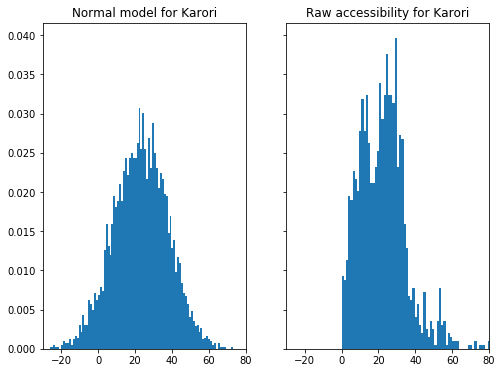

In [38]:
suburb_name = 'Karori'
suburb_df = playground_df[playground_df['suburb'] == suburb_name]
suburb_df_dat = {'n': suburb_df.shape[0],
                 'y': suburb_df['accessibility'].values,}

# Run Stan model for suburb
suburb_trunc_fit = uni_norm_model.sampling(suburb_df_dat, chains=4)

# Plot model posterior predictive against raw values
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8,6))
ax1.hist(suburb_trunc_fit['y_pred'], bins=100, density=True);
ax1.set_title('Normal model for {:s}'.format(suburb_name));
plt.xlim(-30,80)

ax2.hist(suburb_df['accessibility'], bins=100, density=True);
ax2.set_title('Raw accessibility for {:s}'.format(suburb_name));
plt.xlim(-30,80)
    

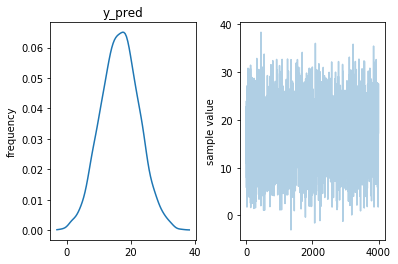

In [39]:
fig = hataitai_fit.plot(pars=['y_pred'])
fig.subplots_adjust(hspace=1.0, wspace=0.3)

## Truncated Normal

In [40]:
# Run precompiled model
karori_trunc_dat = {'N': karori.shape[0],
                    'L': 0,
                    'U': 80,
                    'y': karori['accessibility'].values,}
karori_trunc_fit = lower_trunc_norm_model.sampling(karori_trunc_dat, chains=4)
print(karori_trunc_fit)


Inference for Stan model: anon_model_da01b1257b3430beee0da77218725620.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      17.55    0.02   0.82  15.88  17.01  17.59  18.12  19.07   1169    1.0
sigma   18.13    0.02   0.56  17.09  17.74  18.11  18.49  19.29   1245    1.0
y_pred  23.08    0.22  14.14   1.44  11.93  21.65  32.65   53.1   4000    1.0
lp__    -4946    0.03   1.08  -4949  -4946  -4945  -4945  -4945   1025    1.0

Samples were drawn using NUTS at Sat May 11 23:03:31 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


(-30, 80)

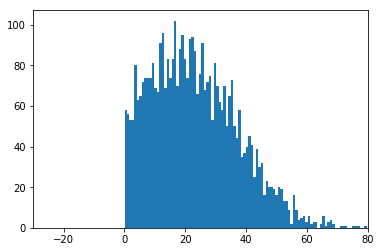

In [41]:
plt.hist(karori_trunc_fit['y_pred'], bins=100);
plt.xlim(-30, 80)

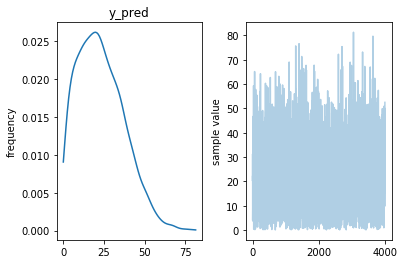

In [42]:
fig = karori_trunc_fit.plot(pars=['y_pred'])
fig.subplots_adjust(hspace=1.0, wspace=0.3)

In [43]:
karori_trunc_fit['y_pred']

array([22.00378287, 20.17230381, 31.27007723, ..., 34.42684909,
       15.40266759, 52.49256071])

## Checking model performance with posterior predictive

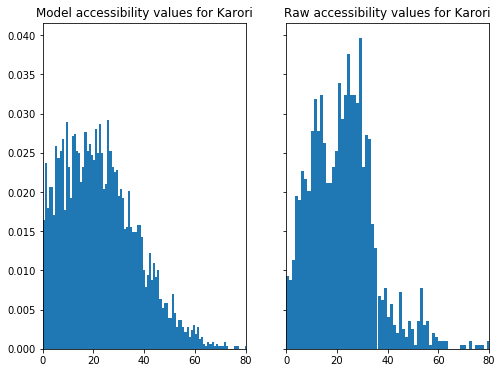

In [44]:
karori_fit = su.run_plot_suburb_stan(playground_df, lower_trunc_norm_model)

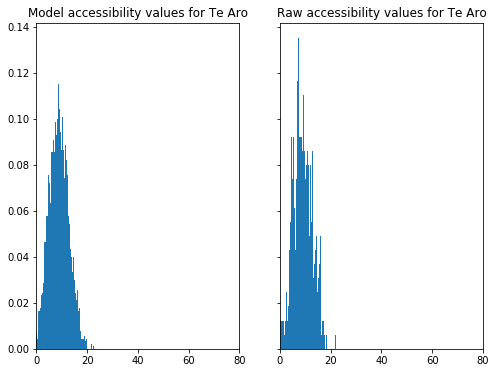

In [45]:
tearo_fit = su.run_plot_suburb_stan(playground_df, lower_trunc_norm_model, 'Te Aro')

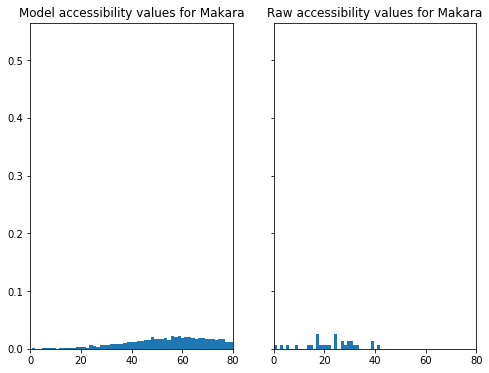

In [46]:
makara_fit = su.run_plot_suburb_stan(playground_df, lower_trunc_norm_model, 'Makara')

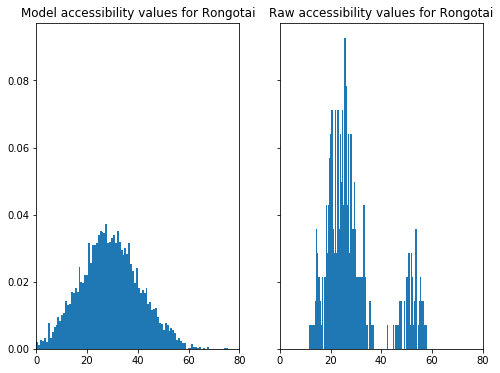

In [47]:
suburb_fit = su.run_plot_suburb_stan(playground_df, lower_trunc_norm_model, 'Rongotai')

## Hierarchical modelling

In [48]:
norm_hier_model = su.load_or_generate_stan_model('stan', 'univariate_normal_hierarchical_single_level')

stan/univariate_normal_hierarchical_single_level.pkl


In [49]:
norm_hier_model_cent = su.load_or_generate_stan_model('stan', 'univariate_normal_hierarchical_single_level_centered')

stan/univariate_normal_hierarchical_single_level_centered.pkl


In [50]:
summary_df = playground_df['suburb'].value_counts().reset_index().rename({'suburb': 'counts',
                                                                         'index': 'suburb'}, axis=1)
summary_df['cumulative'] = summary_df['counts'].cumsum()
summary_df['fraction'] = summary_df['cumulative'] / summary_df['counts'].sum()

top_80 = summary_df[summary_df['fraction'] <= 0.80]
top_80.head(10)

,suburb,counts,cumulative,fraction
0,Karori,1619,1619,0.104210
1,Miramar,1208,2827,0.181964
2,Brooklyn,802,3629,0.233587
3,Te Aro,743,4372,0.281411
4,Newtown,729,5101,0.328334
5,Tawa,603,5704,0.367147
6,Island Bay,602,6306,0.405896
7,Johnsonville,550,6856,0.441298
8,Kelburn,493,7349,0.473030
9,Mount Victoria,442,7791,0.501480


In [51]:
top_80_df = playground_df[playground_df['suburb'].isin(top_80['suburb'])]
top_80_df = su.convert_categorical_to_ID(top_80_df, 'suburb')


In [52]:
reload(su)
hier_summary_2 = su.train_acc_hierarchical(top_80_df,
                                           norm_hier_model,
                                           return_levels_stanfit = True) 

In [53]:
hier_summary_2['stanfit']

Inference for Stan model: anon_model_8e1cf432d03a78f6f8fe41c8d6494cf9.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_l[0]       8.81    0.11   1.62   5.49   7.84    9.0   9.94  11.16    234    1.0
mu_l[1]      11.54    0.02   0.54  10.52  11.18  11.57  11.91  12.56    500    1.0
mu_l[2]      11.32    0.02   0.42  10.51  11.05  11.32  11.59  12.15    500    1.0
mu_l[3]       8.99    0.08   1.39   5.87   8.19   9.07  10.01  11.35    271    1.0
mu_l[4]      26.19    0.02   0.35  25.52  25.95  26.19  26.45  26.83    500    1.0
mu_l[5]      28.54    0.03   0.75  27.09   28.0  28.51  29.04  30.09    500    1.0
mu_l[6]      17.65    0.04   0.85  15.74  17.14   17.7  18.22  19.18    500   1.01
mu_l[7]        8.9  7.2e-3   0.16   8.59   8.79    8.9   9.01   9.22    500    1.0
mu_l[8]      14.06    0.04   0.93  12.21  13.38  14.11  14.72  15.7

In [ ]:
reload(su)
hier_summary_cent = su.train_acc_hierarchical(top_80_df,
                                           norm_hier_model_cent,
                                           return_levels_stanfit = True) 

## Plot average accessibility at suburban level

In [887]:
summ = hier_summary_2['stanfit'].summary(['mu_m'])
summ_df = pd.DataFrame(summ['summary'],
                       columns=(u'mean', u'se_mean', u'sd', u'hpd_2.5',u'hpd_25',
                                u'hpd_50',u'hpd_75',u'hpd_97.5',u'n_eff',u'Rhat'),
                       index=summ['summary_rownames']).reset_index()

Text(20.80000000000001, 0.5, '')

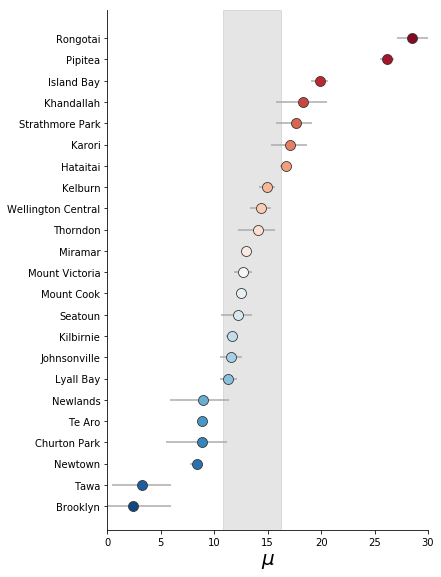

In [889]:
df_plot = su.df_for_forestplot(hier_summary_2['stanfit'], top_80_df, 'mu_l', 'suburb_id')
df_plot_sort = df_plot.sort_values('mean')
su.custom_forestplot(df_plot_sort, 'suburb', size=8, aspect=0.8, facetby=None, 
                     avg_min=summ_df['hpd_2.5'][0], avg_max=summ_df['hpd_97.5'][0])
plt.xlim(0, 30)
plt.xlabel('$\mu$', size=20)
plt.ylabel('')

In [890]:
df_plot

,index,mean,se_mean,sd,hpd_2.5,hpd_25,hpd_50,hpd_75,hpd_97.5,n_eff,Rhat,ypos,suburb
0,mu_l[0],8.811920,0.105971,1.621049,5.487433,7.840005,9.002371,9.935698,11.163111,234.0,0.997999,0,Churton Park
1,mu_l[1],11.542421,0.024170,0.540447,10.524593,11.180405,11.565696,11.911710,12.562399,500.0,0.998198,1,Johnsonville
2,mu_l[2],11.318424,0.018749,0.419234,10.514659,11.050510,11.322219,11.592589,12.148097,500.0,1.000345,2,Lyall Bay
3,mu_l[3],8.987805,0.084408,1.389527,5.872613,8.188782,9.073300,10.005487,11.353686,271.0,1.000652,3,Newlands
4,mu_l[4],26.189760,0.015506,0.346727,25.520780,25.953086,26.188692,26.446181,26.831352,500.0,0.998131,4,Pipitea
5,mu_l[5],28.540351,0.033588,0.751053,27.089057,28.002423,28.506275,29.043969,30.087154,500.0,0.998647,5,Rongotai
6,mu_l[6],17.650823,0.037842,0.846179,15.744027,17.137777,17.704049,18.224870,19.181802,500.0,1.010710,6,Strathmore Park
7,mu_l[7],8.901505,0.007154,0.159962,8.594219,8.790442,8.904644,9.008640,9.220547,500.0,0.999518,7,Te Aro
8,mu_l[8],14.064208,0.041790,0.934457,12.207773,13.383473,14.108049,14.722342,15.707675,500.0,1.005541,8,Thorndon
9,mu_l[9],16.736541,0.013240,0.296051,16.176170,16.544056,16.736907,16.937339,17.292489,500.0,0.998068,9,Hataitai


## Plot accessibility variation at suburban level

In [891]:
summ = hier_summary_2['stanfit'].summary(['mu_s'])
summ_df = pd.DataFrame(summ['summary'],
                       columns=(u'mean', u'se_mean', u'sd', u'hpd_2.5',u'hpd_25',
                                u'hpd_50',u'hpd_75',u'hpd_97.5',u'n_eff',u'Rhat'),
                       index=summ['summary_rownames']).reset_index()

Text(20.80000000000001, 0.5, '')

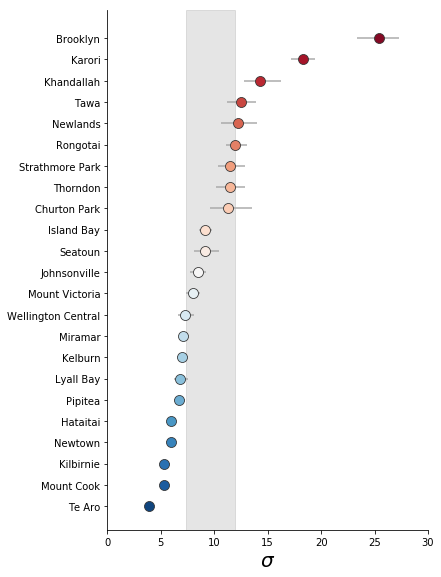

In [892]:
df_plot = su.df_for_forestplot(hier_summary_2['stanfit'], top_80_df, 'sigma_l', 'suburb_id')
df_plot_sort = df_plot.sort_values('mean')
su.custom_forestplot(df_plot_sort, 'suburb', size=8, aspect=0.8, facetby=None, 
                     avg_min=summ_df['hpd_2.5'][0], avg_max=summ_df['hpd_97.5'][0])
plt.xlim(0,30)
plt.xlabel('$\sigma$', size=20)
plt.ylabel('')

## Plot average and variation by suburb

In [893]:
# Get individual suburb distribution summaries
df_plot_sigma = su.df_for_forestplot(hier_summary_2['stanfit'], top_80_df, 'sigma_l', 'suburb_id')
df_plot_mu = su.df_for_forestplot(hier_summary_2['stanfit'], top_80_df, 'mu_l', 'suburb_id')

# Summarise all suburb distribution
summ_sigma_df = su.summarise_variable(hier_summary_2['stanfit'], 'mu_s')
summ_mu_df = su.summarise_variable(hier_summary_2['stanfit'], 'mu_m')


In [894]:
# Rename suburban average df
df_plot_mu = df_plot_mu[['mean', 'hpd_2.5', 
                         'hpd_97.5', 'suburb']].rename({'mean': 'mu_mean',
                                                        'hpd_2.5': 'mu_hpd_2.5',
                                                        'hpd_97.5': 'mu_hpd_97.5'},
                                                axis=1)

# Rename suburban variation df
df_plot_sigma = df_plot_sigma[['mean', 'hpd_2.5', 
                               'hpd_97.5', 'suburb']].rename({'mean': 'sigma_mean',
                                                              'hpd_2.5': 'sigma_hpd_2.5',
                                                              'hpd_97.5': 'sigma_hpd_97.5'}, 
                                                      axis=1)


# Normalise
df_plot_mu['mu_norm'] = df_plot_mu['mu_mean'] - summ_mu_df['mean'][0]
df_plot_sigma['sigma_norm'] = df_plot_sigma['sigma_mean'] - summ_sigma_df['mean'][0]

# Join normalised mean and sigma by suburb
df_all = pd.merge(df_plot_mu, df_plot_sigma)

In [895]:
def colorpoint(row):
    if (row['sigma_norm'] < -2.35) & (row['mu_norm'] < -2.35):
        return('y')
    if (row['sigma_norm'] < -2.35) & (row['mu_norm'] > 2.26):
        return('g')
    if (row['sigma_norm'] > 2.26) & (row['mu_norm'] > 2.26):
        return('r')
    if (row['sigma_norm'] > 2.26) & (row['mu_norm'] < -2.35):
        return('b')
    else:
        return('k')
    
def legend(row):
    if (row['sigma_norm'] < -2.35) & (row['mu_norm'] < -2.35):
        return('Low $\sigma$ and $mu$')
    if (row['sigma_norm'] < -2.35) & (row['mu_norm'] > 2.26):
        return('Low $\sigma$; High $\mu$')
    if (row['sigma_norm'] > 2.26) & (row['mu_norm'] > 2.26):
        return('High $\sigma$ and $\mu$')
    if (row['sigma_norm'] > 2.26) & (row['mu_norm'] < -2.35):
        return('High $\sigma$; Low $\mu$')
    else:
        return('')

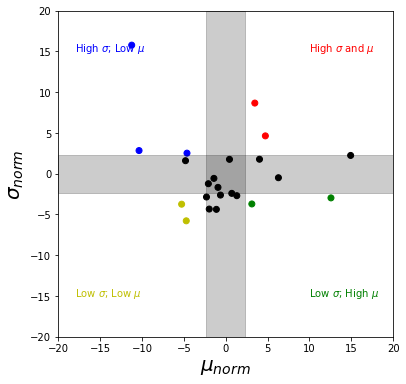

In [896]:
# Colour extremes into quadrants
df_all['color'] = df_all.apply (lambda row: colorpoint(row),axis=1)
df_all['labels'] = df_all.apply (lambda row: legend(row),axis=1)

# Plot
x = df_all['mu_norm']
y = df_all['sigma_norm']
c = df_all['color']

plt.figure(figsize=(6,6))
plt.scatter(x, y, color=c)
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.xlabel('$\mu_{norm}$', size=20)
plt.ylabel('$\sigma_{norm}$', size=20)

# Label figure into quadrants
plt.axhspan(-2.35, 2.26, color='k', alpha=0.2)
plt.axvspan(-2.35, 2.26, color='k', alpha=0.2)
plt.text(10, 15, 'High $\sigma$ and $\mu$', color='r');
plt.text(10, -15, 'Low $\sigma$; High $\mu$', color='g');
plt.text(-18, 15, 'High $\sigma$; Low $\mu$', color='b');
plt.text(-18, -15, 'Low $\sigma$; Low $\mu$', color='y');

In [897]:
df_all

,mu_mean,mu_hpd_2.5,mu_hpd_97.5,suburb,mu_norm,sigma_mean,sigma_hpd_2.5,sigma_hpd_97.5,sigma_norm,color,labels
0,8.811920,5.487433,11.163111,Churton Park,-4.804474,11.264981,9.644012,13.492103,1.597595,k,
1,11.542421,10.524593,12.562399,Johnsonville,-2.073972,8.442223,7.708558,9.243401,-1.225163,k,
2,11.318424,10.514659,12.148097,Lyall Bay,-2.297969,6.811343,6.245523,7.545993,-2.856043,k,
3,8.987805,5.872613,11.353686,Newlands,-4.628588,12.190420,10.626995,14.032725,2.523033,b,High $\sigma$; Low $\mu$
4,26.189760,25.520780,26.831352,Pipitea,12.573367,6.702840,6.214374,7.278882,-2.964546,g,Low $\sigma$; High $\mu$
5,28.540351,27.089057,30.087154,Rongotai,14.923957,11.910157,11.070945,13.072341,2.242771,k,
6,17.650823,15.744027,19.181802,Strathmore Park,4.034430,11.443268,10.323429,12.911709,1.775881,k,
7,8.901505,8.594219,9.220547,Te Aro,-4.714889,3.891348,3.676540,4.138993,-5.776039,y,Low $\sigma$ and $mu$
8,14.064208,12.207773,15.707675,Thorndon,0.447814,11.430552,10.155717,12.858341,1.763166,k,
9,16.736541,16.176170,17.292489,Hataitai,3.120148,5.960217,5.578005,6.361081,-3.707169,g,Low $\sigma$; High $\mu$


In [898]:
(df_all[df_all['color']
        .isin(['r', 'b', 'y', 'g'])]
 .sort_values(['labels'])[['suburb', 'labels', 'mu_norm', 'sigma_norm']])

,suburb,labels,mu_norm,sigma_norm
15,Khandallah,High $\sigma$ and $\mu$,4.736581,4.641167
22,Karori,High $\sigma$ and $\mu$,3.475087,8.664240
3,Newlands,High $\sigma$; Low $\mu$,-4.628588,2.523033
11,Tawa,High $\sigma$; Low $\mu$,-10.355696,2.839867
21,Brooklyn,High $\sigma$; Low $\mu$,-11.234330,15.768424
7,Te Aro,Low $\sigma$ and $mu$,-4.714889,-5.776039
18,Newtown,Low $\sigma$ and $mu$,-5.269459,-3.736698
4,Pipitea,Low $\sigma$; High $\mu$,12.573367,-2.964546
9,Hataitai,Low $\sigma$; High $\mu$,3.120148,-3.707169


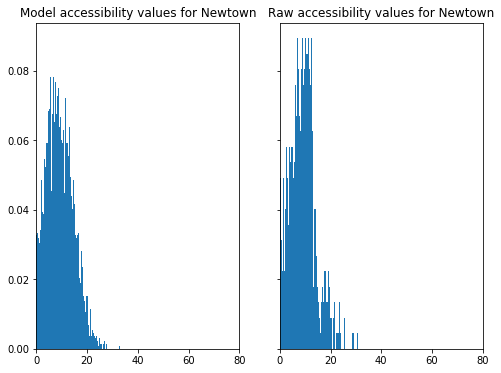

In [899]:
su.run_plot_suburb_stan(top_80_df, lower_trunc_norm_model, 'Newtown')

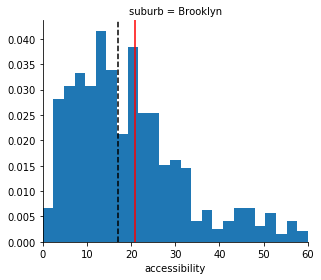

In [900]:
df_sel = playground_df[playground_df['suburb'].isin(['Brooklyn'])]

g = sns.FacetGrid(col='suburb', data=df_sel, size=4, col_wrap=5)
g.map(plt.hist, 'accessibility', normed=True, bins=50)
g.map(ut.vertical_average_lines, 'accessibility')
plt.xlim(0,60);

(array([2., 0., 4., 6., 4., 3., 2., 0., 0., 2.]),
 array([ 2.38206386,  4.99789255,  7.61372125, 10.22954994, 12.84537864,
        15.46120733, 18.07703603, 20.69286472, 23.30869342, 25.92452211,
        28.5403508 ]),
 <a list of 10 Patch objects>)

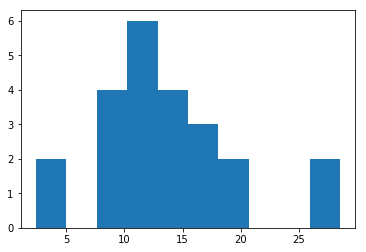

In [908]:
df_pp = pd.merge(df_all, summary_df)
plt.hist(df_pp['mu_mean'])

# Hilliness of park environs

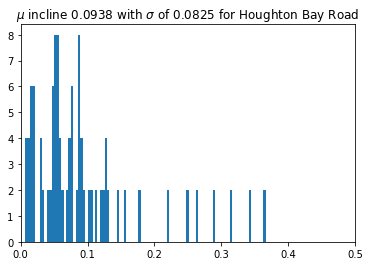

In [902]:
i = 16
z = ox.truncate_graph_dist(G, 
                           ox.utils.get_nearest_node(G, tuple(wcc_playgrounds.ix[i][['lat', 'lon']])), 
                           max_distance=500, 
                           weight='length')

n_z, e_z = ox.graph_to_gdfs(z)
plt.hist(e_z['grade_abs'], bins=100);
plt.title('$\mu$ incline {} with $\sigma$ of {} for {}'.format(round(np.mean(e_z['grade_abs']), 4),
                                                               round(np.std(e_z['grade_abs']), 4),
                                                               wcc_playgrounds.ix[i]['location']))
plt.xlim(0, 0.5);

In [903]:
# Run precompiled model
park_trunc_dat = {'N': e_z.shape[0],
                  'L': 0,
                  'U': 80,
                  'y': e_z['grade_abs'].values,}
park_trunc_fit = lower_trunc_norm_model.sampling(park_trunc_dat, chains=4)
print(park_trunc_fit)


Inference for Stan model: anon_model_da01b1257b3430beee0da77218725620.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       0.01  3.3e-4   0.01 3.5e-4 4.5e-3   0.01   0.02   0.04   1102    1.0
sigma    0.12  2.5e-4 9.0e-3    0.1   0.12   0.12   0.13   0.14   1277    1.0
y_pred    0.1  1.2e-3   0.08 4.2e-3   0.04   0.09   0.15   0.29   4000    1.0
lp__   269.06    0.04   1.12 265.92 268.65 269.41 269.86 270.15    992    1.0

Samples were drawn using NUTS at Sat May 11 20:16:12 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


(0, 0.5)

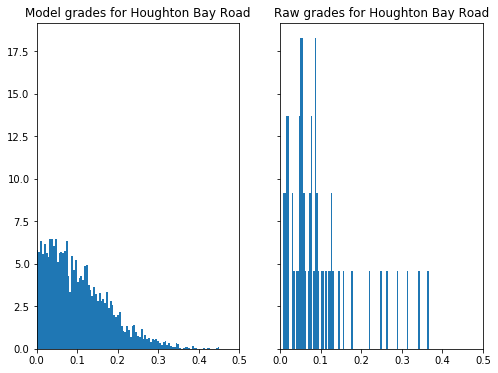

In [904]:
# Plot model posterior predictive against raw values
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8,6))
ax1.hist(park_trunc_fit['y_pred'], bins=100, density=True);
ax1.set_title('Model grades for {:s}'.format(wcc_playgrounds.ix[i]['location']));
ax1.set_xlim(0, 0.5)

ax2.hist(e_z['grade_abs'], bins=100, density=True);
ax2.set_title('Raw grades for {:s}'.format(wcc_playgrounds.ix[i]['location']));
ax2.set_xlim(0, 0.5)

# Incorporating LINZ residential spatial filter

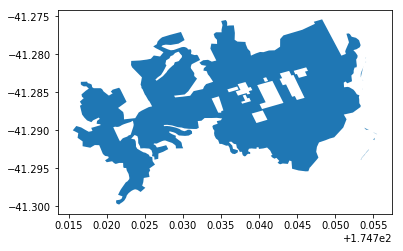

In [905]:
karori_residence = wlg_res_poly_suburbs_ov[(wlg_res_poly_suburbs_ov['suburb'] == 'Karori') & 
                                           (~wlg_res_poly_suburbs_ov['t50_fid'].isnull())]
karori_residence.plot()

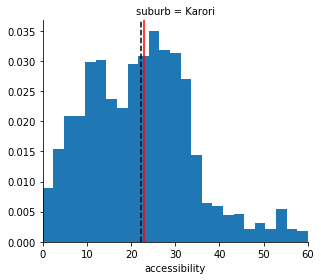

In [906]:
# Get lat and lon coordinates for accessibility values
orig_nodes = network_hills.nodes_df 
df_joined = pd.merge(orig_nodes.reset_index(), total_hills_1.reset_index(), how='inner')
df_joined.columns = ['node_id', 'lon', 'lat', 'accessibility']

# Convert lat and lon to geoseries
df_joined_coords = dp.coords_df_to_geopandas_points(df_joined, crs={'init': 'epsg:4167'})

# Extract only the residential polygons
res_polys_only = wlg_res_poly_suburbs_ov[(~wlg_res_poly_suburbs_ov['t50_fid'].isnull())]

# Get accessibility within residential polygons
playground_res_df = geopandas.sjoin(res_polys_only, df_joined_coords, op='contains').drop('index_right', axis=1)

# Get accessibility for Karori
karori_acc = playground_df[playground_df['suburb'].isin(['Karori'])]

# Plot
g = sns.FacetGrid(col='suburb', data=karori_acc, size=4, col_wrap=5)
g.map(plt.hist, 'accessibility', normed=True, bins=50)
g.map(ut.vertical_average_lines, 'accessibility')
plt.xlim(0,60);
#plt.ylim(0, 0.0035);